https://towardsdatascience.com/the-definitive-way-to-deal-with-continuous-variables-in-machine-learning-edb5472a2538

In [3]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
boston = load_boston()

In [3]:
boston_df = pd.DataFrame(boston['data'] )

In [21]:
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,BIN_CHAS,BIN_NOX,BIN_RM,BIN_AGE,BIN_DIS,BIN_RAD,BIN_TAX,BIN_PTRATIO,BIN_B,BIN_LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,0,2,3,1,3,0,1,0,3,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,0,1,3,2,3,0,0,1,3,1
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,0,1,4,1,3,0,0,1,2,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,0,1,4,1,4,0,0,2,3,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,0,1,4,1,4,0,0,2,3,0


In [5]:
boston_df = pd.DataFrame(boston['data'] )
boston_df.columns = boston['feature_names']
boston_df['PRICE'] = boston['target']

In [16]:
n_bins = 5

qt = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')

In [17]:
qt

KBinsDiscretizer(encode='ordinal')

In [18]:
scaled_feature_names = [f"BIN_{x}" for x in boston['feature_names']]

In [19]:
scaled_feature_names

['BIN_CRIM',
 'BIN_ZN',
 'BIN_INDUS',
 'BIN_CHAS',
 'BIN_NOX',
 'BIN_RM',
 'BIN_AGE',
 'BIN_DIS',
 'BIN_RAD',
 'BIN_TAX',
 'BIN_PTRATIO',
 'BIN_B',
 'BIN_LSTAT']

In [20]:
boston_df[scaled_feature_names] = qt.fit_transform(boston_df[boston['feature_names']])
boston_df[scaled_feature_names] = boston_df[scaled_feature_names].astype(int)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\preprocessing\_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\preprocessin

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

class QuantizedFeaturesEmbedding(layers.Layer):
  def __init__(self,
               n_features,
               n_bins,
               embed_dim,
               **kwargs):
    super(QuantizedFeaturesEmbedding, self).__init__(**kwargs)
    self.n_features = n_features
    self.n_bins = n_bins
    self.embed_dim = embed_dim

    assert self.n_features > 0
    assert self.n_bins > 0
    assert self.embed_dim > 0

  def build(self, input_shape=None):
    self.embeddings = self.add_weight(
        shape=(self.n_features, self.n_bins, self.embed_dim),
        initializer=tf.keras.initializers.GlorotUniform(),
        name='quantized_features_embeddings')
    self.built = True

  def _enumerate(self, ids):
    '''
    input: [[1,0,2,1], [0,2,1,1]]
    output: [[(0,1), (1,0), (2,2), (3,1)],
             [(0,0), (1,2), (2,1), (3,1)]]
    so that, for the first input:
    A[(0,1)] = feature 0, embedding 1
    A[(1,0)] = feature 1, embedding 0
    A[(2,2)] = feature 2, embedding 2
    A[(3,1)] = feature 3, embedding 1
    '''
    bs = ids.shape[0]
    pos = tf.expand_dims(tf.range(0, self.n_features), axis=0) # (0,1,2,..nf)
    pos = tf.tile(pos, tf.constant([bs, 1])) # repeat for this batch
    tf.assert_equal(pos.shape, ids.shape) 
    return tf.stack([pos, ids], axis=-1)

  def call(self, ids):
    '''
    Input shape:
      2D tensor with shape (batch_size, n_features)
    Output shape:
      3D tensor with shape (batch_size, n_features, embed_dim)
    '''
    assert ids.shape[1] == self.n_features

    ids = tf.cast(ids, tf.int32)
    idx = self._enumerate(ids)
    return tf.gather_nd(self.embeddings, idx)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers

class QuantizedFeaturesEmbedding(layers.Layer):
  def __init__(self,
               n_features,
               n_bins,
               embed_dim,
               **kwargs):
    super(QuantizedFeaturesEmbedding, self).__init__(**kwargs)
    self.n_features = n_features
    self.n_bins = n_bins
    self.embed_dim = embed_dim

    assert self.n_features > 0
    assert self.n_bins > 0
    assert self.embed_dim > 0

  def build(self, input_shape=None):
    self.embeddings = self.add_weight(
        shape=(self.n_features, self.n_bins, self.embed_dim),
        initializer=tf.keras.initializers.GlorotUniform(),
        name='quantized_features_embeddings')
    self.built = True

  def _enumerate(self, ids):
    '''
    input: [[1,0,2,1], [0,2,1,1]]
    output: [[(0,1), (1,0), (2,2), (3,1)],
             [(0,0), (1,2), (2,1), (3,1)]]
    so that, for the first input:
    A[(0,1)] = feature 0, embedding 1
    A[(1,0)] = feature 1, embedding 0
    A[(2,2)] = feature 2, embedding 2
    A[(3,1)] = feature 3, embedding 1
    '''
    bs = ids.shape[0]
    pos = tf.expand_dims(tf.range(0, self.n_features), axis=0) # (0,1,2,..nf)
    pos = tf.tile(pos, tf.constant([bs, 1])) # repeat for this batch
    tf.assert_equal(pos.shape, ids.shape) 
    return tf.stack([pos, ids], axis=-1)

  def call(self, ids):
    '''
    Input shape:
      2D tensor with shape (batch_size, n_features)
    Output shape:
      3D tensor with shape (batch_size, n_features, embed_dim)
    '''
    assert ids.shape[1] == self.n_features

    ids = tf.cast(ids, tf.int32)
    idx = self._enumerate(ids)
    return tf.gather_nd(self.embeddings, idx)

In [2]:
np.concatenate([-np.inf, bin_edges_[i][1:-1], np.inf])

NameError: name 'np' is not defined

In [10]:
import matplotlib.pyplot as plt

In [9]:
X = [[-2, 1, -4,   -1], 
     [-1, 2, -3, -0.5],   
     [ 0, 3, -2,  0.5],  
     [ 1, 4, -1,    2]]
X

[[-2, 1, -4, -1], [-1, 2, -3, -0.5], [0, 3, -2, 0.5], [1, 4, -1, 2]]

In [25]:
x = [-2, 1, -4, -1,-1, 2, -3, -0.5, 0, 3, -2, 0.5, 1, 4, -1, 2]
x

[-2, 1, -4, -1, -1, 2, -3, -0.5, 0, 3, -2, 0.5, 1, 4, -1, 2]

In [27]:
x.sort()
x

[-4, -3, -2, -2, -1, -1, -1, -0.5, 0, 0.5, 1, 1, 2, 2, 3, 4]

(array([1., 1., 2., 3., 1., 2., 2., 2., 1., 1.]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <BarContainer object of 10 artists>)

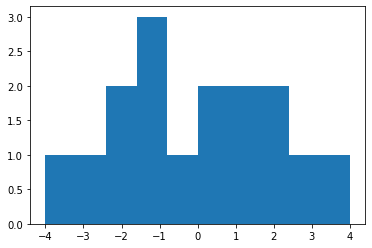

In [29]:
y = np.arange(16)
plt.hist(x)

In [30]:
est = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
est.fit(X)

KBinsDiscretizer(encode='ordinal', n_bins=4, strategy='uniform')

In [31]:
Xt = est.transform(X)
Xt 

array([[0., 0., 0., 0.],
       [1., 1., 1., 0.],
       [2., 2., 2., 2.],
       [3., 3., 3., 3.]])

In [38]:
Xt.argsort()

array([[0, 1, 2, 3],
       [3, 0, 1, 2],
       [0, 1, 2, 3],
       [0, 1, 2, 3]], dtype=int64)